<a href="https://colab.research.google.com/github/JoeL-8883/DL-Assignment/blob/optical_flow/DL_coursework_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Coursework 2025
# Action classification

In this coursework you are asked to propose, implement and evaluate a deep learning approach for **action classification from videos**.

For this purpose, we will make use of the simple Weizmann dataset

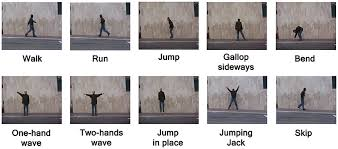


It has the advantage to be small and relatively simple, so you should be able to devise solutions with limited computing resources.

The task is as follows:
- your model should take *a sequence of between 5 and 50 frames as input and output one class label out of the 10 possible actions featured in the dataset.*
- The videos in the dataset have a resolution of `144x180` but we will crop the images to `3x128x128` for simplicity (I recommend you make use of that in your data augmentation) - your model can process the images in a smaller resolution if you want.  
- You should provide a function named `classify` that takes as input a tensor that is of shape `50x3x128x128` and return a single integer in `[0,9]` for the action such that: `{0: walk, 1: run, 2: jump, 3: side, 4: bend, 5: wave1, 6: wave2, 7: pjump, 8: jack, 9: skip}`.
- Your code should provide a function for downloading the weights of the trained model from an online source (of your choice).

The approach you choose for doing this is entirely up to you, but you must factor in the time and computational limitations you are under - consider the assignment to be more about building a prototype/proof of concept that final product.

### Hand-in date: Wednesday 12th of March before 4:30pm (on Moodle)

### Steps & Hints
* First, look at the data. What are the different classes? How different are they? What type of transformations for your data augmentation do you think would be acceptable here?.
  * Note that the dataset is rather small (hint: you will need to think about data augmentation!).
  * You will probably want to generate subsequences of different length from each videos by selecting random start and end points to extend the dataset.
* Second, try and load the data and separate into training, validation and test set (or better, use cross-validation)
  * Write a DataLoader class for the data (Hint: you will want to put the data augmentation in the data loader).
  * Think about pre-processing of the input? The output? Normalisation or not? Data augmentation? Which one?
* Design a network for the task. What layers? How many? Do you want to use an Autoencoder for unsupervised pre-training?
* Choose a loss function for your network
* Select optimiser and training parameters (batch size, learning rate)
* Optimise your model, and tune hyperparameters (especially learning rate, momentum etc)
* Analyse the results on the test data. How to measure success? Which classes are recognised well, which are not? Is there confusion between some classes? Look at failure cases.
* If time allows, go back to drawing board and try a more complex, or better, model.
* Explain your thought process, justify your choices and discuss the results!

### Submission
* submit ONE zip file on Moodle containing:
  * **your notebook**: use `File -> download .ipynb` to download the notebook file locally from colab.
  * **a PDF file** of your notebook's output as you see it: use `File -> print` to generate a PDF.
* your notebook must clearly contains separate cells for:
  * setting up your model and data loader
  * training your model from data
  * loading your pretrained model from github/gitlab
  * testing your model on test data.
* The training cells must be disabled by a flag, such that when running *run all* on your notebook it does
  * load the data
  * load your model (from your online source of choice)
  * apply the model to the test data
  * analyse and display the results and accuracy
* In addition provide markup cell:
  * containing your student number at the top
  * to **describe and motivate ALL your design choices**: architecture, pre-processing, training regime.
  * to analyse, describe and comment on your results
  * to provide some discussion on what you think are the limitations of your solution and what could be future work.

* **Note 1: you must put your trained model on an online source so that your code can download it.**
* **Note 2: you must put your discussion in markup cells, not in code comments.**

## Assessement
The main aim of this coursework **is not performance**. The main criterion will be whether you can demonstrate that you have proposed a sensible approach and that you have evaluated it rigorously.

I recommend starting with a simple architecture as baseline, then try an improvement on it.

Your report should discuss the following points:
- What pre-processing do you use - if any - and why?
- What is your architecture. Discuss each component and justify.
- What is the loss you are using?
- What is your training procedure? Has the model converged (provide convergence curves in your report)?
- How does the model perform? What are the failure cases? How well would you expect it to generalise?
- What approach would you use if you had another 4 weeks and a A100 to work on this?

Bonus goals (not required but interesting things to try if you're done with the above):
- evaluate the reliability of your results using multiple seeds for training your model and reporting the mean and standard deviation.
- Test your method on a different dataset. How well does it work? Do you have to change your architecture to make it work? If yes what?

### Marking criteria
* In order to get a pass mark, you will need to demonstrate that you have designed and trained a deep NN to solve the problem, using sensible approach and reasonable efforts to tune hyper-parameters. You have analysed the results. It is NOT necessary to have any level of accuracy (a network that predicts poorly will always yield a pass mark if it is designed, tuned and analysed sensibly).
* In order to get a good mark, you will demonsrate an understanding of the approach you have chosen, justifying each design decision and provide a working solution (again, high performance is not critical here).
* in order to get a high mark, you will demonstrate a working approach of gradual improvement between different versions of your solution.
* bonus marks for attempting something original if well motivated - even if it does not yield increased performance.
* bonus marks for getting high performance.

### Notes
* make sure to clearly set aside training, validation and test sets to ensure proper setting of all hyperparameters.
* I recommend to start with small models that can be easier to train to set a baseline performance before attempting more complex one.
* Be mindful of the time!
* Compute capabilities are limited, so plan accordingly (make sure that all bugs are gone before you start training in anger!)






## Getting the data

You can download the dataset as a zip file from here:

[DOWNLOAD LINK](https://mega.nz/file/omlVQJrB#OJGx0r90H4ymNt7ZhikVGmroQFN0TDvgnH5ssIjRuJ0)

**Note:** you should store this data on your Google drive or any other convenient place so you do not have to redownload it everytime you spin an instance.

You can then unzip it, eg:

In [1]:
!gdown --id 1QVK62Szl7-IxstMns34Q9VGeVbM4sgjB

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1QVK62Szl7-IxstMns34Q9VGeVbM4sgjB
From (redirected): https://drive.google.com/uc?id=1QVK62Szl7-IxstMns34Q9VGeVbM4sgjB&confirm=t&uuid=ccda227d-524f-4001-b9c3-9a274f091ddf
To: /content/dataset.zip
100% 353M/353M [00:06<00:00, 52.4MB/s]


In [2]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: videos/
   creating: videos/run/
  inflating: videos/run/daria_run.avi  
  inflating: videos/run/ido_run.avi  
  inflating: videos/run/lena_run1.avi  
  inflating: videos/run/denis_run.avi  
  inflating: videos/run/eli_run.avi  
  inflating: videos/run/moshe_run.avi  
  inflating: videos/run/lena_run2.avi  
  inflating: videos/run/lyova_run.avi  
  inflating: videos/run/ira_run.avi  
  inflating: videos/run/shahar_run.avi  
   creating: videos/wave1/
  inflating: videos/wave1/ira_wave1.avi  
  inflating: videos/wave1/ido_wave1.avi  
  inflating: videos/wave1/lena_wave1.avi  
  inflating: videos/wave1/lyova_wave1.avi  
  inflating: videos/wave1/moshe_wave1.avi  
  inflating: videos/wave1/eli_wave1.avi  
  inflating: videos/wave1/denis_wave1.avi  
  inflating: videos/wave1/shahar_wave1.avi  
  inflating: videos/wave1/daria_wave1.avi  
   creating: videos/jump/
  inflating: videos/jump/ira_jump.avi  
  inflating: videos/jump/daria_jump.avi  
  inflating:

Each folder correspond to one specific action, and contains videos that can be opened using any library: Eg, using torchvision:

In [1]:
!pip install av
from torchvision.io import read_video, write_video

# we select one of the video arbitrarily
video_avi, _, fps = read_video('videos/walk/daria_walk.avi', pts_unit='sec')

# note the shape of the output tensor
print(video_avi.shape)

torch.Size([84, 144, 180, 3])


The video is loaded by torchvision as a tensor of dimension: frames x height x width x channels (so you'll have to reshape that for pytorch!).

You can easily visualise individual frames using, eg, matplotlib:

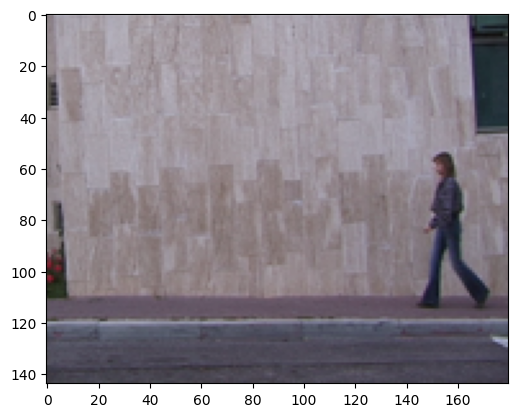

In [2]:
import matplotlib.pyplot as plt

# let's display the first image
plt.imshow(video_avi[5,...])

The 10 classes in the dataset are as follows:

In [3]:
classes = {
    0: 'walk',
    1: 'run',
    2: 'jump',
    3: 'side',
    4: 'bend',
    5: 'wave1',
    6: 'wave2',
    7: 'pjump',
    8: 'jack',
    9: 'skip'
    }

Remember:
- to split the videos into subvideos
- to use appropriate data augmentation (eg, crops)
- you'll (probably) want to have part of your architecture focusing on processing the image and part for processing the sequence.


It's up to you now - have fun!!

### Load the data (including preprocessng)

In [14]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
from torchvision.transforms.functional import rgb_to_grayscale
import numpy as np
import cv2
import time

class BuildDataset(Dataset):
    def __init__(self, dataset_dir, sub_iter=10, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.data = [] # store data as (video, label) pairs
        self.flag = False
        self.classes = {
            'walk': 0,
            'run': 1,
            'jump': 2,
            'side': 3,
            'bend': 4,
            'wave1': 5,
            'wave2': 6,
            'pjump': 7,
            'jack': 8,
            'skip': 9
        }

        '''Populate the dataset'''
        for action in os.listdir(dataset_dir):
            action_dir = os.path.join(dataset_dir, action)
            for video in os.listdir(action_dir):
                video_dir = os.path.join(action_dir, video)
                bw_video = self.convert_bw(video_dir)
                cropped_video = self.crop_image(bw_video)
                self.data.append((cropped_video, self.classes[action], cropped_video.shape[0]))

                flipped_video = self.flip_video(cropped_video)
                self.data.append((flipped_video, self.classes[action], flipped_video.shape[0]))

                for i in range(sub_iter):
                    sub_video = self.subsequence_video(cropped_video)
                    sub_flipped_video = self.flip_video(sub_video)

                    self.data.append((sub_video, self.classes[action], sub_video.shape[0]))
                    self.data.append((sub_flipped_video, self.classes[action], sub_flipped_video.shape[0]))

        # Calculate optical flows
        flows = []
        for video, label, length in self.data:
          flow = self.calculate_optical_flow(video)
          flows.append((flow, label, length))
        self.data = flows


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video, label, length = self.data[idx]
        return video, label, length

    def convert_bw(self, video):
        video_tensor, _, info = read_video(video)
        gray_frames = []

        '''Convert each frame to grayscale'''
        for frame in video_tensor:
            frame = frame.permute(2, 0, 1) # rearrange tensor to (channels, height, width)
            gray = rgb_to_grayscale(frame, num_output_channels=1)
            gray_frames.append(gray)

        gray_video = torch.stack(gray_frames)
        gray_video = gray_video.permute(0, 2, 3, 1) # convert back to (num_frames, height, width, channels)
        gray_video = gray_video.squeeze(-1) # remove the last channel
        return gray_video

    # Crop to 128 x 128
    def crop_image(self, frame):
        _, h, w = frame.shape

        # Get the top left corner
        top = (h - 128) // 2
        left = (w - 128) // 2

        return frame[:, top:top+128, left:left+128]

    def flip_video(self, video):
        return torch.flip(video, dims=[-1])

    def subsequence_video(self, video):
        number_frames = video.shape[0]
        fraction = torch.randint(1, 10, (1,))/10
        length = int(number_frames*fraction)
        try:
            start = np.random.randint(0, len(video) - length)
            end = start + length
            return video[start:end]
        except:
            print("Warning.")
            print(video.shape)

    def calculate_optical_flow(self, video, single_frame=None):
        '''Darken background for much cleaner signal'''
        def subtract_background(video, frames):
            processed = []
            bg_subtractor = cv2.createBackgroundSubtractorMOG2(
                history=frames, varThreshold=16, detectShadows=False
            )

            for i in range(frames):
                frame = video[i]
                fg_mask = bg_subtractor.apply(frame)
                processed.append(fg_mask)
            return np.array(processed)

        video = video.cpu().numpy()
        frames = video.shape[0]
        video = subtract_background(video, frames)
        flows = []

        for i in range(frames - 1):
            previous = video[i]
            next = video[i + 1]

            # Blur to reduce noise
            previous_blurred = cv2.GaussianBlur(previous, (9, 9), 0)
            next_blurred = cv2.GaussianBlur(next, (9, 9), 0)

            flow = cv2.calcOpticalFlowFarneback(prev=previous_blurred, next=next_blurred, flow=None, pyr_scale=0.5, levels=15, winsize=15, iterations=20, poly_n=5, poly_sigma=1.8, flags=0)
            flows.append(flow)

        return torch.tensor(flows)

In [15]:
dataset = BuildDataset('videos', sub_iter=1) # Generates a dataset of videos stored as tensors, with labels
print(len(dataset))

/usr/local/lib/python3.11/dist-packages/torchvision/io/video.py:169: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


372


In [16]:
# Make each video the same length so I can batch them
def collate_fn(batch):
    videos, labels, lengths = zip(*batch)

    max_len = max(lengths)
    padded_videos = []
    for video in videos:
        num_frames = video.shape[0]
        padding = torch.zeros(max_len - num_frames, 128, 128)
        padded_video = torch.cat((video, padding), 0)
        padded_videos.append(padded_video)
    return torch.stack(padded_videos), torch.tensor(labels)

## Dataloader

In [17]:
from torch.utils.data import DataLoader, random_split

# Split the dataset
train_split = 0.8
train_size = int(train_split * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# Create data loaders
BATCH_SIZE = 5
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Set shuffle to false to test on same samples

## Model

In [18]:
import torch.nn as nn
import torch.nn.functional as F

# Only predicting one or two classes - so I use skip connections to let gradients flow better
class Residual(nn.Module):
    def __init__(self):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        x = F.relu(self.conv1(x))
        x = x + residual
        return x

class CNN(nn.Module):
    def __init__(self, shape):
        super(CNN, self).__init__()

        self.shape = shape
        self.pool = nn.MaxPool2d(2, 2)
        self.res = Residual()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc1 = nn.Linear(64 * (shape//4) * (shape//4), 128)

        self.flatten = nn.Flatten(start_dim=1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.01)
        x = self.bn1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.01)

        x = self.res(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.bn3(x)
        return x

class LSTM(nn.Module):
    def __init__(self, shape, num_classes=10):
        super(LSTM, self).__init__()
        self.shape = shape
        self.cnn = CNN(shape)
        self.lstm = nn.LSTM(128, 64, batch_first=True)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        batch_size, frames, h, w = x.size()
        x = x.view(batch_size * frames, 1, h, w)
        x = self.cnn(x)
        x = x.view(batch_size, frames, -1)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        return x

In [19]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param, nonlinearity='relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)

## Run model

In [20]:
frame_shape = (1, 128, 128)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(frame_shape[1], num_classes=10)
model = model.to(device)
model.apply(init_weights)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Epochs
epochs = 12

'''Training loop'''
print('Training...')
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()

        videos = videos.float()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')


Training...


RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [19]:
'''Testing loop'''
print('Testing...')
model.eval()
correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():
    for videos, labels, lengths in test_loader:
        videos ,labels = videos.to(device), labels.to(device)
        videos = videos.float()

        outputs = model(videos)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = 100 * correct / total
avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Testing...
Test Loss: 1.8925, Accuracy: 58.31%
